In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as patches

plt.rcParams.update({
    'font.size': 26,  # Set the default font size
    'text.color': 'k',  # Set the default font color
    'xtick.labelsize': 26,  # Set the font size for x-axis tick labels
    'ytick.labelsize': 26,  # Set the font size for y-axis tick labels
    'legend.fontsize': 26,  # Set the font size for legends
    'axes.labelsize': 26,  # Set the font size for axes labels
})

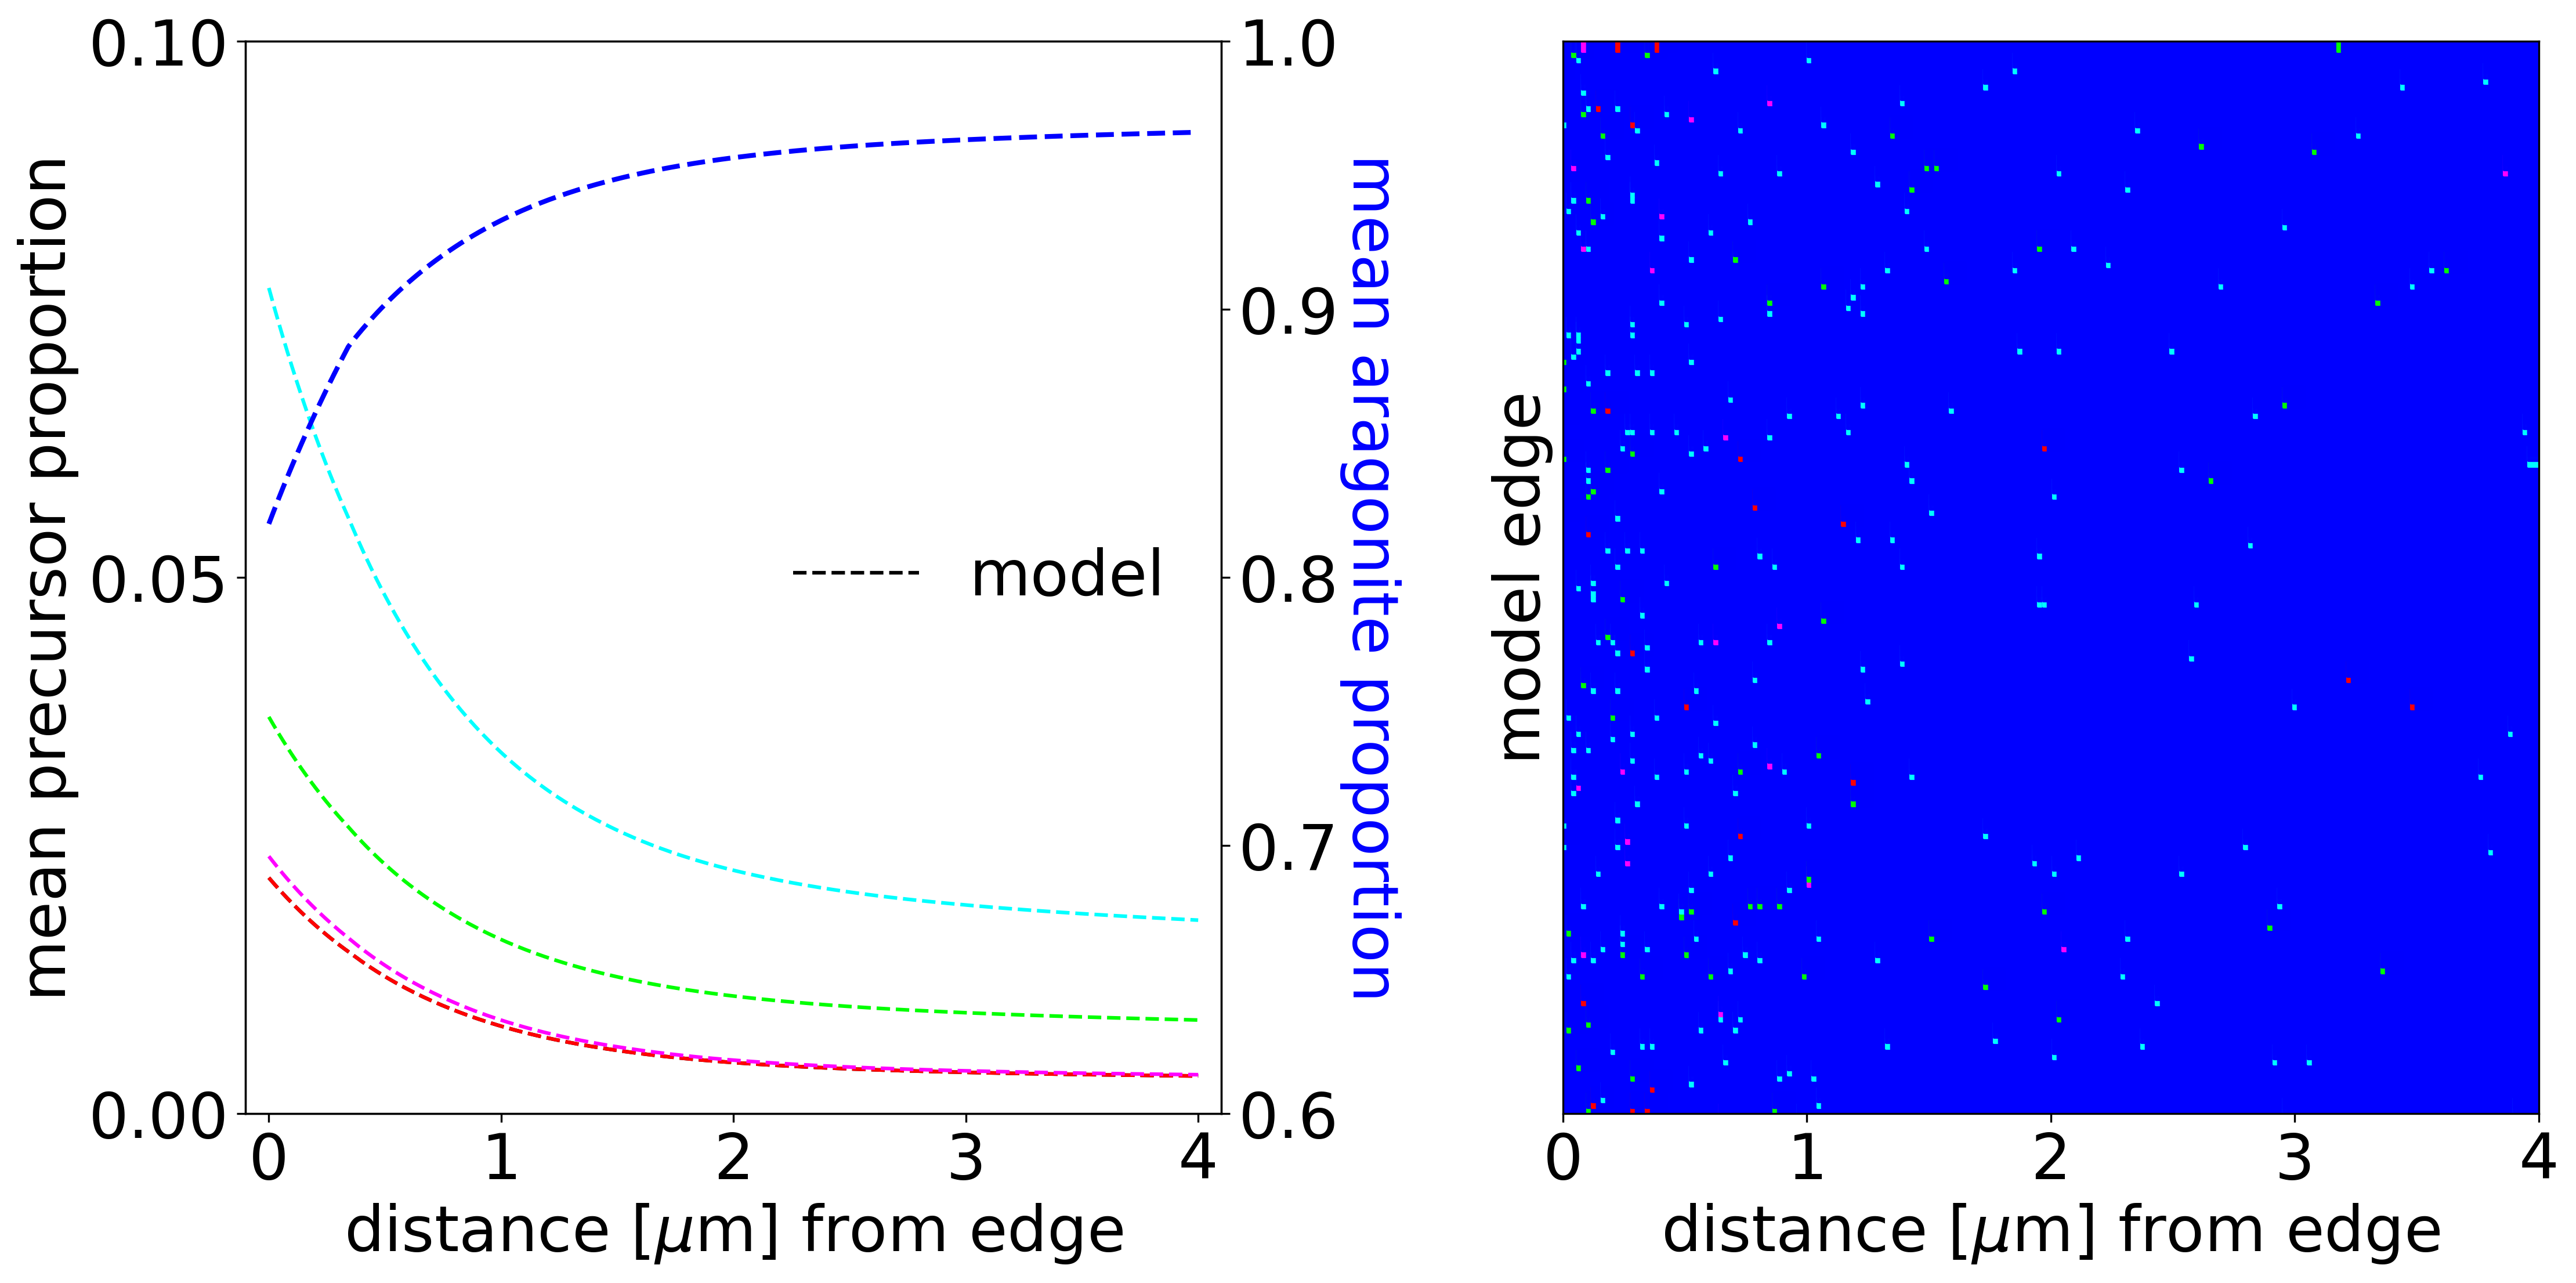

In [5]:
#define the model
def model_parallel_with_influx(t, y, k, influx):
    # y layout: [P1, P2, P3, P4, A]
    P = y[:4]
    A = y[4]  
    dP_dt = -k * P + influx
    dA_dt = k * np.sum(P)
    return np.concatenate([dP_dt, [dA_dt]])

#check to see if sum of precursors is 1
def cap_to_unit_mass(P, A):
    M = P.sum() + A
    if M <= 1.0:
        return P, A
    
    if M > 1.0:
        print('my volume is not constant')
        scale = 1.0 / M
        P_cap = P * scale
        A_cap = A * scale
        return P_cap, A_cap
    else:
        return P, A

# initial conditions
k = 1/.7
influx = np.array([.006,.015,.031,.0062])
P0 = np.array([0.022, 0.037, 0.077, 0.024])
A0 = .82
y0 = np.concatenate([P0, [A0]])

# Time grid
x_span = (0.0, 4.)
x_eval = np.linspace(*x_span, 200)

# Solve with a wrapper that applies the cap after each evaluation
def system(x, y):
    # y is 5-vector: P1..P4, A
    P = y[:4]
    A = y[4]
    dP_dx = -k * P + influx
    dA_dx = k * np.sum(P)
    return np.concatenate([dP_dx, [dA_dx]])

sol1 = solve_ivp(system, x_span, y0, t_eval=x_eval)

# Apply cap at evaluation points if necessary
P_sol = sol1.y[:4, :].copy()
A_sol = sol1.y[4, :].copy()
P_cap = P_sol.copy()
A_cap = A_sol.copy()

for j in range(P_sol.shape[1]):
    Pj = P_sol[:, j]
    Aj = A_sol[j]
    M = Pj.sum() + Aj
    if M > 1.0:
        if M > 0:
            scale = 1.0 / M
            P_cap[:, j] = Pj * scale
            A_cap[j] = Aj * scale
        else:
            P_cap[:, j] = 0.0
            A_cap[j] = 0.0


P = P_cap
A1 = A_cap

# Sampling settings to build model MM
Nsamples_per_x = 4
num_x = sol1.t.size
y_levels = np.linspace(0, 4, 200)
Mlev = len(y_levels)

# Dominant category per (x, level) batch
rng = np.random.default_rng(0)
dominant_points = []

for j in range(num_x):
    probs = np.array([P[0, j], P[1, j], P[2, j], P[3, j], A1[j]])
    s = probs.sum()
    if s <= 0:
        continue
    p_norm = probs / s
    for m in range(Mlev):
        ys_level = y_levels[m]
        cats = rng.choice(5, size=Nsamples_per_x, p=p_norm)
        counts = np.bincount(cats, minlength=1)
        dominant = int(np.argmax(counts))
        dominant_points.append((sol1.t[j], ys_level, dominant))


dominant_points = np.array(dominant_points, dtype=[('x', float), 
                                                   ('y', float), ('cat', int)])
dx = dominant_points['x']
dy = dominant_points['y']
dcat = dominant_points['cat']

#plot
color_map = {0: 'red', 1: 'lime', 2: 'cyan', 3: 'magenta', 4: 'blue'}
point_colors = np.array([color_map[int(c)] for c in dcat], dtype=object)
fig,ax = plt.subplots(1,2,figsize=(17,8),dpi=300)
ax[1].scatter(dx, dy, color=point_colors, s=70, alpha=0.99, marker='s')
ax[1].set_xlabel('distance [$\mu$m] from edge')
ax[1].set_ylabel('model edge')
ax[1].set_yticks([])
S=3
ax[0].plot(sol1.t, P[0], label=f'model',color='black',linestyle='dashed')

ax[0].plot(sol1.t, P[0]#, #label=f'toy ACCH2O'
           ,color='red',linestyle='dashed')
ax[0].plot(sol1.t, P[1]#, #label=f'toy ACC'
           ,color='lime',linestyle='dashed')
ax[0].plot(sol1.t, P[2]#, #label=f'toy CCHH'
           ,color='cyan',linestyle='dashed')
ax[0].plot(sol1.t, P[3]#, #label=f'toy MHC'
           ,color='magenta',linestyle='dashed')

twin = ax[0].twinx()
twin.set_ylim(.6,1)
twin.set_yticks([.6,.7,.8,.9,1.])
twin.set_yticklabels(['0.6','0.7','0.8','0.9','1.0'])
twin.plot(sol1.t , A1, label='toy aragonite', color='blue', 
          linewidth=2,linestyle='dashed')
twin.set_ylabel('mean aragonite proportion',
                rotation = 270,
                labelpad=26,
                color='blue')

ax[0].set_xlabel('distance [$\mu$m] from edge')
ax[0].set_ylabel('mean precursor proportion')
ax[0].legend(framealpha=False,loc='center right')

ax[0].set_ylim(0,.1)
ax[0].set_yticks([0,.05,.1])
ax[1].set_xlim(-.0,4.0)
ax[0].set_xlim(-0.1,4.1)
ax[1].set_ylim(-.0,4.0)
ax[0].set_xticks([0,1,2,3,4])
ax[1].set_xticks([0,1,2,3,4])

plt.subplots_adjust(wspace=0.35)
plt.show()